### Fraud Analytics Assignment 3 :
### Team Members : 
### 1.CS22BTECH11012 - Bolla NehaSree
### 2.CS22BTECH11043 - Nethi Keerthana
### 3.ES22BTECH11025 - N.Krishna Chaitanya

### This script implements a Variational Autoencoder (VAE) in PyTorch and performs a grid search over different hyperparameters to find the best configuration. It trains the VAE on a normalized dataset using different combinations of latent dimensions, hidden layer sizes, learning rates, batch sizes, and epochs. The Mean Squared Error (MSE) and KL divergence are used to compute the loss. After training, the best hyperparameter set is determined based on the lowest reconstruction loss.

In [170]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from itertools import product
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# Set device to CPU explicitly
device = torch.device("cpu")

# Load and normalize dataset
data = pd.read_csv("data.csv").values
scaler = StandardScaler()
data = scaler.fit_transform(data)  # Normalize data

# Convert dataset to PyTorch tensor
data_tensor = torch.tensor(data, dtype=torch.float32).to(device)


# Define Variational Autoencoder class
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dims, latent_dim):
        super(VAE, self).__init__()

        # Encoder
        encoder_layers = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            encoder_layers.append(nn.Linear(prev_dim, h_dim))
            encoder_layers.append(nn.ReLU())
            prev_dim = h_dim
        encoder_layers.append(nn.Linear(prev_dim, latent_dim * 2))  # Mean and Log-variance
        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder
        decoder_layers = []
        prev_dim = latent_dim
        for h_dim in reversed(hidden_dims):
            decoder_layers.append(nn.Linear(prev_dim, h_dim))
            decoder_layers.append(nn.ReLU())
            prev_dim = h_dim
        decoder_layers.append(nn.Linear(prev_dim, input_dim))
        decoder_layers.append(nn.Sigmoid())
        self.decoder = nn.Sequential(*decoder_layers)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x)
        mu, log_var = encoded[:, :latent_dim], encoded[:, latent_dim:]
        z = self.reparameterize(mu, log_var)
        reconstructed = self.decoder(z)
        return reconstructed, mu, log_var, z


'''# Define hyperparameter grid (reduced for efficiency)
latent_dims = [2]  
hidden_dims_list = [[32], [128], [64, 32], [128, 64]]  
learning_rates = [0.001, 0.002]  
batch_sizes = [16, 32]  
epochs_list = [50]'''

latent_dims = [2]  
hidden_dims_list = [[128,32],[128, 64]]  
learning_rates = [0.001,0.002]  
batch_sizes = [16,32]  
epochs_list = [50]


# Store best parameters
best_loss = float("inf")
best_params = {}

# Run grid search over hyperparameters
for latent_dim, hidden_dims, lr, batch_size, epochs in product(latent_dims, hidden_dims_list, learning_rates, batch_sizes, epochs_list):
    vae = VAE(input_dim=data.shape[1], hidden_dims=hidden_dims, latent_dim=latent_dim).to(device)
    optimizer = optim.AdamW(vae.parameters(), lr=lr) 
    loss_fn = nn.MSELoss()

    # Create DataLoader
    dataset = TensorDataset(data_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Training loop
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in dataloader:
            batch_data = batch[0].to(device)  # Move batch to device

            optimizer.zero_grad()
            reconstructed, mu, log_var, _ = vae(batch_data)

            # Compute losses
            recon_loss = loss_fn(reconstructed, batch_data)
            kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())  # Mean instead of sum
            total_loss = recon_loss + kl_loss

            total_loss.backward()
            optimizer.step()
            epoch_loss += total_loss.item()

    avg_loss = epoch_loss / len(dataloader)
    print(f"Latent Dim: {latent_dim}, Hidden Dim: {hidden_dims}, LR: {lr}, Batch Size: {batch_size}, Epochs: {epochs}, Loss: {avg_loss:.6f}")

    if avg_loss < best_loss:
        best_loss = avg_loss
        best_params = {
            "latent_dim": latent_dim,
            "hidden_dim": hidden_dims,
            "learning_rate": lr,
            "batch_size": batch_size,
            "epochs": epochs
        }

print("\nBest Parameters Found:", best_params)
print("Lowest Loss:", best_loss)


Latent Dim: 2, Hidden Dim: [128, 32], LR: 0.001, Batch Size: 16, Epochs: 50, Loss: 0.999800
Latent Dim: 2, Hidden Dim: [128, 32], LR: 0.001, Batch Size: 32, Epochs: 50, Loss: 0.995218
Latent Dim: 2, Hidden Dim: [128, 32], LR: 0.002, Batch Size: 16, Epochs: 50, Loss: 0.999815
Latent Dim: 2, Hidden Dim: [128, 32], LR: 0.002, Batch Size: 32, Epochs: 50, Loss: 0.995964
Latent Dim: 2, Hidden Dim: [128, 64], LR: 0.001, Batch Size: 16, Epochs: 50, Loss: 0.999961
Latent Dim: 2, Hidden Dim: [128, 64], LR: 0.001, Batch Size: 32, Epochs: 50, Loss: 0.998905
Latent Dim: 2, Hidden Dim: [128, 64], LR: 0.002, Batch Size: 16, Epochs: 50, Loss: 0.999821
Latent Dim: 2, Hidden Dim: [128, 64], LR: 0.002, Batch Size: 32, Epochs: 50, Loss: 0.995256

Best Parameters Found: {'latent_dim': 2, 'hidden_dim': [128, 32], 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50}
Lowest Loss: 0.9952178111201838


### This code retrieves the best hyperparameters from the grid search, initializes a VAE model with the optimal settings, and saves the trained model's state as "best_vae.pth" for future use.

In [171]:
best_latent_dim = best_params["latent_dim"]
best_hidden_dim = best_params["hidden_dim"]
best_lr = best_params["learning_rate"]
best_batch_size = best_params["batch_size"]
best_epochs = best_params["epochs"]

# Save trained model
vae_state_dict = vae.state_dict()
vae = VAE(input_dim=10, hidden_dims=best_hidden_dim, latent_dim=best_latent_dim)
torch.save(vae_state_dict, "best_vae.pth")

### This code loads the trained VAE model, ensures compatibility with saved parameters, and encodes the input data into a latent space representation, making it ready for further analysis like clustering.

In [172]:
# Load the trained model while ensuring correct key-value pairs
checkpoint = torch.load("best_vae.pth", map_location=torch.device("cpu"))  # Ensure compatibility

model_dict = vae.state_dict()  # Get current model parameters
pretrained_dict = {k: v for k, v in checkpoint.items() if k in model_dict and model_dict[k].shape == v.shape}

# Update the model's state dict with matching parameters only
model_dict.update(pretrained_dict)
vae.load_state_dict(model_dict, strict=False)  # Load filtered parameters

vae.eval()  # Set to evaluation mode

# Convert data to tensor
data_tensor = torch.tensor(data, dtype=torch.float32)

# Encode data into the latent space
with torch.no_grad():
    encoded = vae.encoder(data_tensor)
    
    # Ensure correct slicing based on latent_dim
    mu, log_var = encoded[:, :best_latent_dim], encoded[:, best_latent_dim:]
    
    # Reparameterization trick to get latent representation
    z = vae.reparameterize(mu, log_var)

    # Convert latent data to NumPy for further use (e.g., clustering)
    latent_data = z.numpy()

print("Data successfully compressed into latent representation.")


Data successfully compressed into latent representation.


### This script clusters the latent representations using K-Means after scaling and applying PCA (if needed). It evaluates different cluster sizes (K) using Silhouette Scores, smooths the scores, and plots them to find the optimal number of clusters (best K). Finally, it fits K-Means with the best K and assigns cluster labels.

PCA skipped: Using original scaled data.
K=10, Silhouette Score=0.3296
K=11, Silhouette Score=0.3291
K=12, Silhouette Score=0.3298
K=13, Silhouette Score=0.3326
K=14, Silhouette Score=0.3291
K=15, Silhouette Score=0.3263
K=16, Silhouette Score=0.3285
K=17, Silhouette Score=0.3350
K=18, Silhouette Score=0.3328
K=19, Silhouette Score=0.3378
K=20, Silhouette Score=0.3342
K=21, Silhouette Score=0.3368
K=22, Silhouette Score=0.3296
K=23, Silhouette Score=0.3375
K=24, Silhouette Score=0.3307


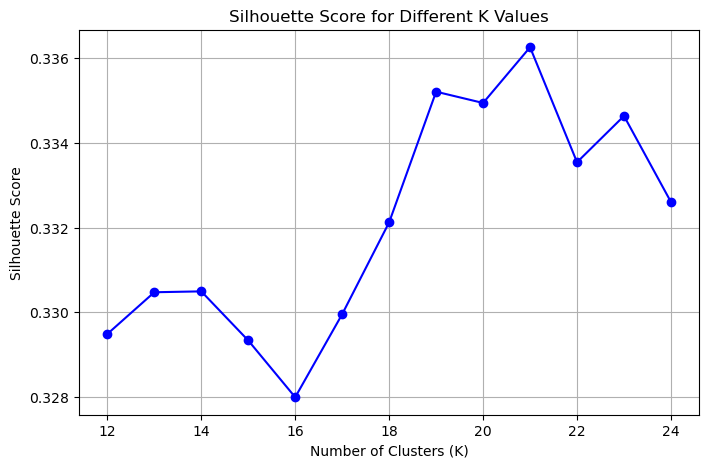

Best K found: 19 with Silhouette Score 0.3378
Clustering completed successfully.


In [173]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Normalize the data using StandardScaler
scaler = StandardScaler()
latent_data_scaled = scaler.fit_transform(latent_data)  # Apply scaling

# Apply PCA to reduce dimensionality
n_features = latent_data_scaled.shape[1]
if n_features > 3:
    pca = PCA(n_components=3)  # Reduce to 3D for better clustering
    latent_data_pca = pca.fit_transform(latent_data_scaled)
    print(f"PCA applied: Reduced data to {latent_data_pca.shape[1]} dimensions.")
else:
    latent_data_pca = latent_data_scaled  # Use original data if already 2D or 3D
    print("PCA skipped: Using original scaled data.")

# Define the range of K values
k_values = list(range(10, min(25, len(latent_data_pca))))  # Reduce unnecessary high K values

silhouette_scores = []
best_k = None
best_silhouette = -1

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=50, init="random")  # Using K-Means (not ++)
    labels = kmeans.fit_predict(latent_data_pca)
    
    score = silhouette_score(latent_data_pca, labels)
    silhouette_scores.append(score)
    print(f"K={k}, Silhouette Score={score:.4f}")

    if score > best_silhouette:
        best_silhouette = score
        best_k = k

# Apply Moving Average Smoothing to the Silhouette Scores
def moving_average(values, window_size=3):
    return np.convolve(values, np.ones(window_size) / window_size, mode="valid")

smoothed_scores = moving_average(silhouette_scores)

# Plot the Smoothed Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(k_values[len(k_values) - len(smoothed_scores):], smoothed_scores, marker='o', linestyle='-', color='b')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Different K Values")
plt.grid(True)
plt.show()

# Ensure we found a valid best_k before proceeding
if best_k is not None:
    print(f"Best K found: {best_k} with Silhouette Score {best_silhouette:.4f}")
    
    # Fit K-Means with the best K
    kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=50, init="random")
    cluster_labels = kmeans.fit_predict(latent_data_pca)
    cluster_centers = kmeans.cluster_centers_
    
    print("Clustering completed successfully.")
else:
    raise ValueError("Could not determine an optimal K for clustering.")

### This script identifies outliers in clustered latent data by detecting:

### Small cluster outliers – Points in clusters with very few members (below a threshold).

### Boundary outliers – Points far from their cluster centers (above the 95th percentile distance).
### It then combines these outliers and prints relevant statistics, including indices of detected outliers.

In [174]:
import numpy as np

# Count the number of points in each cluster
cluster_counts = np.bincount(cluster_labels)

# Find small clusters (clusters with very few points)
small_cluster_threshold = max(5, int(0.03 * len(latent_data)))  # Threshold = 5 or 5% of data
small_clusters = np.where(cluster_counts < small_cluster_threshold)[0]

# Identify small cluster outliers
small_cluster_outliers = np.where(np.isin(cluster_labels, small_clusters))[0]

# Compute distance of each point from its cluster center
distances = np.linalg.norm(latent_data - cluster_centers[cluster_labels], axis=1)

# Define a threshold for "boundary outliers" (95th percentile of distances)
distance_threshold = np.percentile(distances, 95)
boundary_outliers = np.where(distances > distance_threshold)[0]

# Combine all outliers
all_outliers = np.unique(np.concatenate((small_cluster_outliers, boundary_outliers)))

# Print results
print(f"Small Cluster Threshold: {small_cluster_threshold}")
print(f"Small Clusters (Few Data Points): {small_clusters}")
print(f"Total Small Cluster Outliers: {len(small_cluster_outliers)}")
print(f"Small Cluster Outlier Indices: {small_cluster_outliers}")

print("\nBoundary Outliers:")
print(f"Distance Threshold: {distance_threshold}")
print(f"Total Boundary Outliers: {len(boundary_outliers)}")
print(f"Boundary Outlier Indices: {boundary_outliers}")

print("\nAll Outliers Combined:")
print(f"Total Outliers Detected: {len(all_outliers)}")
print(f"Outlier Indices: {all_outliers}")


Small Cluster Threshold: 35
Small Clusters (Few Data Points): [ 4  8  9 12]
Total Small Cluster Outliers: 111
Small Cluster Outlier Indices: [   1    4   10   11   14   17   21   22   71   72   78   80   88  106
  126  127  135  172  179  186  197  200  201  202  232  245  260  285
  287  300  307  311  315  333  339  344  353  359  386  443  463  464
  466  502  519  525  542  550  579  583  612  626  642  655  662  672
  677  678  684  686  694  709  714  733  790  806  807  808  832  835
  846  847  851  860  871  881  896  900  908  915  916  921  923  925
  928  962  969  970  976  980  983  999 1006 1015 1018 1020 1026 1070
 1074 1075 1083 1093 1094 1106 1117 1143 1154 1157 1159 1166 1197]

Boundary Outliers:
Distance Threshold: 0.6733904480934143
Total Boundary Outliers: 60
Boundary Outlier Indices: [   4    6   80  172  188  202  214  234  244  245  285  334  339  340
  370  416  437  441  443  446  450  506  519  529  549  561  589  618
  652  666  677  678  708  709  733  754

### Plot the data points and boundary and small cluster outliers 

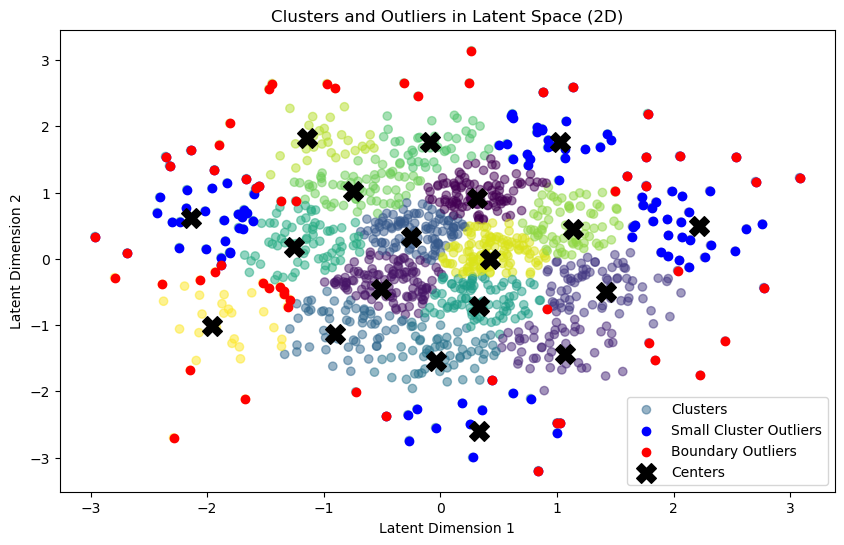

In [175]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(10, 6))

# Plot all points in latent space
plt.scatter(latent_data[:, 0], latent_data[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5, label='Clusters')

# Highlight small cluster outliers in blue
plt.scatter(latent_data[small_cluster_outliers, 0], latent_data[small_cluster_outliers, 1], 
            c='blue', label='Small Cluster Outliers')

# Highlight boundary outliers in red
plt.scatter(latent_data[boundary_outliers, 0], latent_data[boundary_outliers, 1], 
            c='red', label='Boundary Outliers')

# Plot cluster centers in black
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='black', marker="X", s=200, label="Centers")

plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("Clusters and Outliers in Latent Space (2D)")
plt.legend()
plt.show()
